In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
import tensorflow as tf
print(tf.__version__)
import keras
print(keras.__version__)

/home/sunxin/miniconda3/envs/qinhanmin-test/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sunxin/miniconda3/envs/qinhanmin-test/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sunxin/miniconda3/envs/qinhanmin-test/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sunxin/minico

1.13.2
2.2.4


Using TensorFlow backend.


In [2]:
import numpy as np
from keras import layers
from keras import models
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# We create a layer which take as input movies of shape
# (n_frames, width, height, channels) and returns a movie
# of identical shape.

seq = models.Sequential()
seq.add(layers.ConvLSTM2D(filters=40, kernel_size=(3, 3),
                          input_shape=(None, 40, 40, 1),
                          padding='same', return_sequences=True))
seq.add(layers.BatchNormalization())

seq.add(layers.ConvLSTM2D(filters=40, kernel_size=(3, 3),
                          padding='same', return_sequences=True))
seq.add(layers.BatchNormalization())

seq.add(layers.ConvLSTM2D(filters=40, kernel_size=(3, 3),
                          padding='same', return_sequences=True))
seq.add(layers.BatchNormalization())

seq.add(layers.ConvLSTM2D(filters=40, kernel_size=(3, 3),
                          padding='same', return_sequences=True))
seq.add(layers.BatchNormalization())

seq.add(layers.Conv3D(filters=1, kernel_size=(3, 3, 3),
                      activation='sigmoid',
                      padding='same'))
seq.summary()
seq.compile(loss='binary_crossentropy', optimizer='adadelta')

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_1 (ConvLSTM2D)  (None, None, 40, 40, 40)  59200     
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 40, 40, 40)  160       
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, None, 40, 40, 40)  115360    
_________________________________________________________________
batch_normalization_2 (Batch (None, None, 40, 40, 40)  160       
_________________________________________________________________
conv_lst_m2d_3 (ConvLSTM2D)  (None, None, 40, 40, 40)  115360    
_________________________________________________________________
batch_normalization_3 (Batch (None, None, 40, 40, 40)  160       
_________________________________________________________________
conv

In [4]:
# Artificial data generation:
# Generate movies with 3 to 7 moving squares inside.
# The squares are of shape 1x1 or 2x2 pixels,
# which move linearly over time.
# For convenience we first create movies with bigger width and height (80x80)
# and at the end we select a 40x40 window.

def generate_movies(n_samples=1200, n_frames=15):
    row = 80
    col = 80
    noisy_movies = np.zeros((n_samples, n_frames, row, col, 1), dtype=np.float)
    shifted_movies = np.zeros((n_samples, n_frames, row, col, 1),
                              dtype=np.float)

    for i in range(n_samples):
        # Add 3 to 7 moving squares
        n = np.random.randint(3, 8)

        for j in range(n):
            # Initial position
            xstart = np.random.randint(20, 60)
            ystart = np.random.randint(20, 60)
            # Direction of motion
            directionx = np.random.randint(0, 3) - 1
            directiony = np.random.randint(0, 3) - 1

            # Size of the square
            w = np.random.randint(2, 4)

            for t in range(n_frames):
                x_shift = xstart + directionx * t
                y_shift = ystart + directiony * t
                noisy_movies[i, t, x_shift - w: x_shift + w,
                             y_shift - w: y_shift + w, 0] += 1

                # Make it more robust by adding noise.
                # The idea is that if during inference,
                # the value of the pixel is not exactly one,
                # we need to train the network to be robust and still
                # consider it as a pixel belonging to a square.
                if np.random.randint(0, 2):
                    noise_f = (-1) ** np.random.randint(0, 2)
                    noisy_movies[i, t,
                                 x_shift - w - 1: x_shift + w + 1,
                                 y_shift - w - 1: y_shift + w + 1,
                                 0] += noise_f * 0.1

                # Shift the ground truth by 1
                x_shift = xstart + directionx * (t + 1)
                y_shift = ystart + directiony * (t + 1)
                shifted_movies[i, t, x_shift - w: x_shift + w,
                               y_shift - w: y_shift + w, 0] += 1

    # Cut to a 40x40 window
    noisy_movies = noisy_movies[::, ::, 20:60, 20:60, ::]
    shifted_movies = shifted_movies[::, ::, 20:60, 20:60, ::]
    noisy_movies[noisy_movies >= 1] = 1
    shifted_movies[shifted_movies >= 1] = 1
    return noisy_movies, shifted_movies

In [5]:
# Train the network
noisy_movies, shifted_movies = generate_movies(n_samples=1200)
seq.fit(noisy_movies[:1000], shifted_movies[:1000], batch_size=10,
        epochs=50, validation_split=0.05)

Instructions for updating:
Use tf.cast instead.
Train on 950 samples, validate on 50 samples
Epoch 1/50
950/950 [==============================] - 32s 34ms/step - loss: 0.2373 - val_loss: 0.0436
Epoch 2/50
950/950 [==============================] - 27s 28ms/step - loss: 0.0223 - val_loss: 0.0145
Epoch 3/50
950/950 [==============================] - 27s 29ms/step - loss: 0.0041 - val_loss: 0.0037
Epoch 4/50
950/950 [==============================] - 27s 29ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 5/50
950/950 [==============================] - 27s 29ms/step - loss: 8.4410e-04 - val_loss: 0.0014
Epoch 6/50
950/950 [==============================] - 27s 29ms/step - loss: 6.3708e-04 - val_loss: 6.5529e-04
Epoch 7/50
950/950 [==============================] - 27s 29ms/step - loss: 4.9249e-04 - val_loss: 9.9916e-04
Epoch 8/50
950/950 [==============================] - 28s 29ms/step - loss: 5.1048e-04 - val_loss: 4.6040e-04
Epoch 9/50
950/950 [==============================] - 27s 29ms/

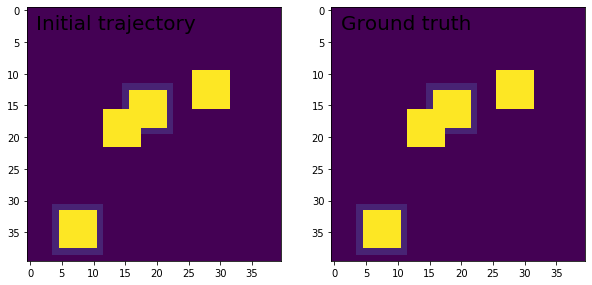

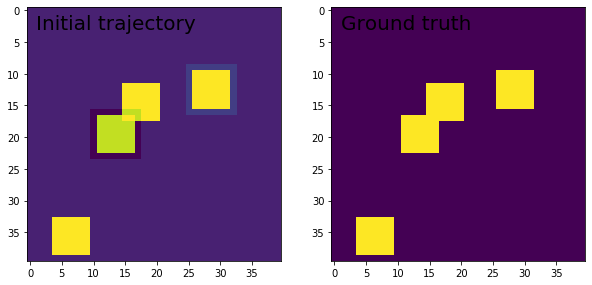

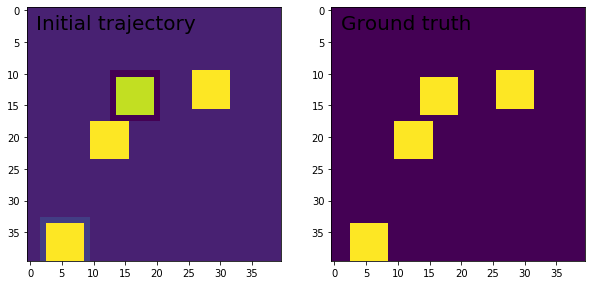

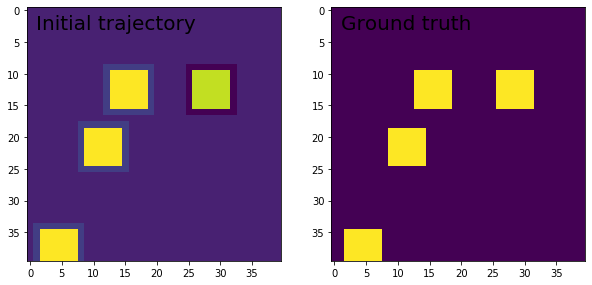

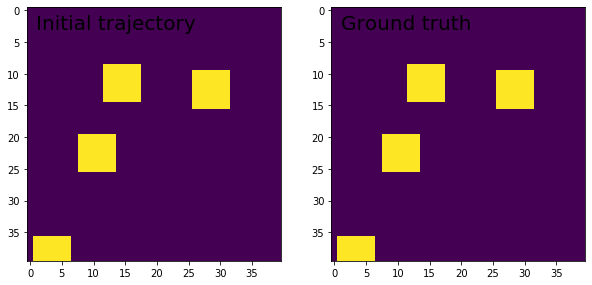

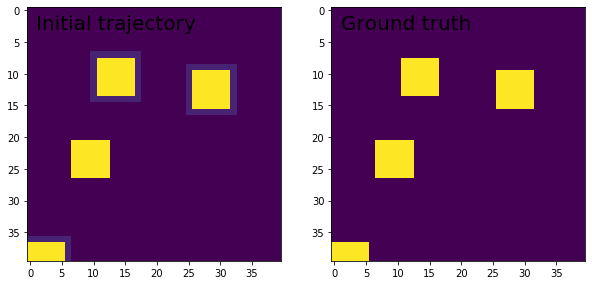

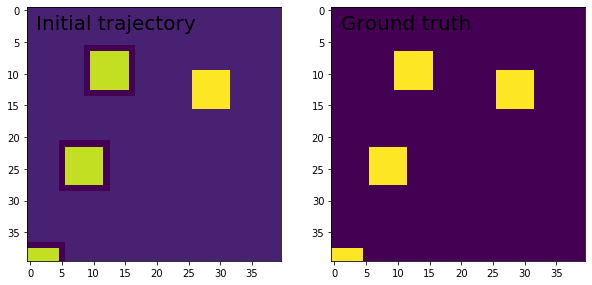

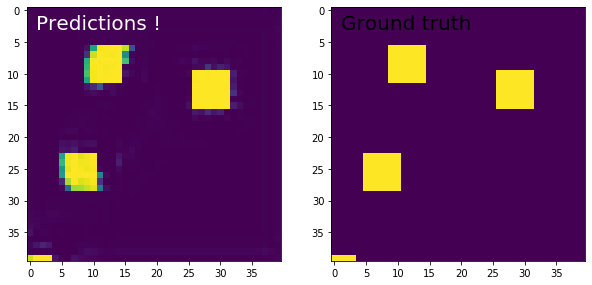

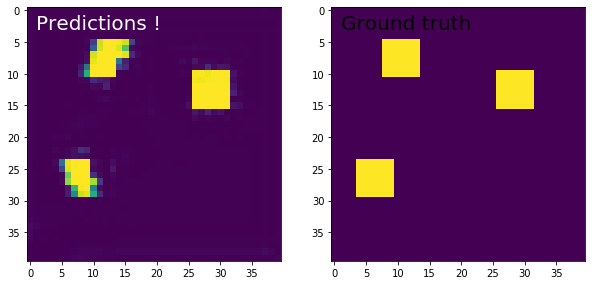

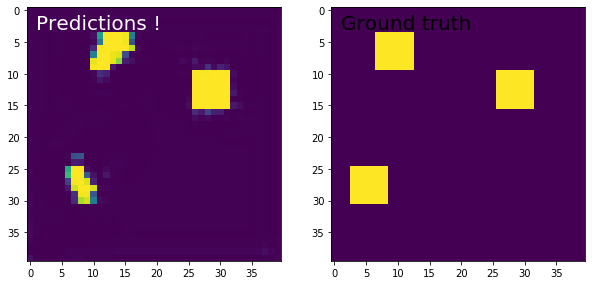

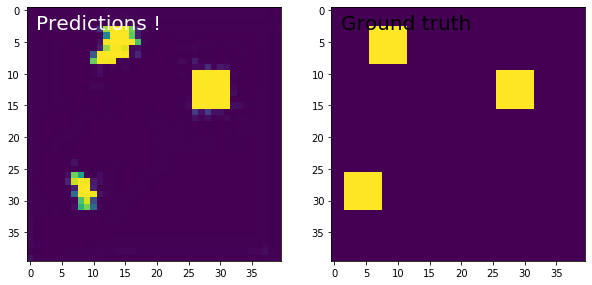

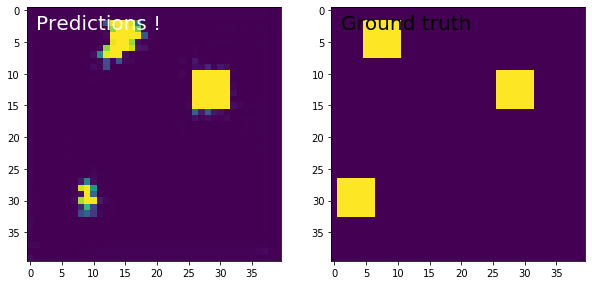

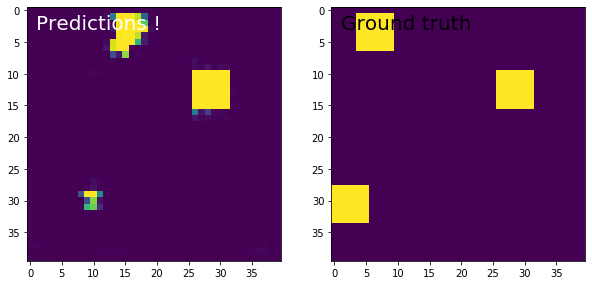

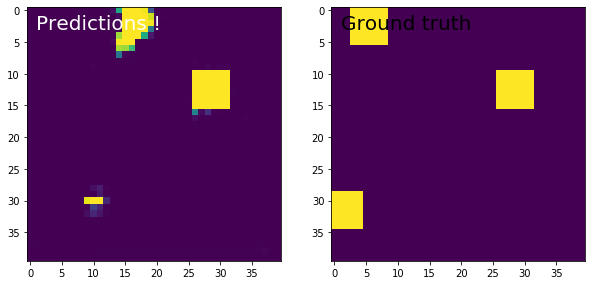

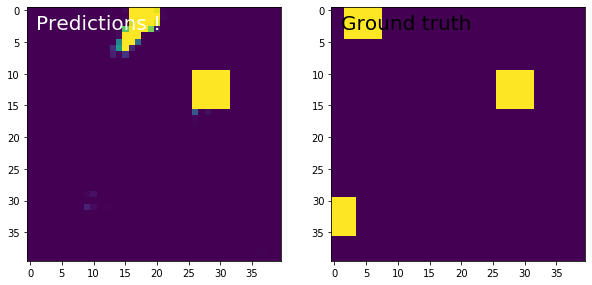

In [6]:
# Testing the network on one movie
# feed it with the first 7 positions and then
# predict the new positions
which = 1004
track = noisy_movies[which][:7, ::, ::, ::]

for _ in range(8):
    new_pos = seq.predict(track[np.newaxis, ::, ::, ::, ::])
    new = new_pos[::, -1, ::, ::, ::]
    track = np.concatenate((track, new), axis=0)


# And then compare the predictions
# to the ground truth
track2 = noisy_movies[which][::, ::, ::, ::]
for i in range(15):
    fig = plt.figure(figsize=(10, 5))

    ax = fig.add_subplot(121)
    if i >= 7:
        ax.text(1, 3, 'Predictions !', fontsize=20, color='w')
    else:
        ax.text(1, 3, 'Initial trajectory', fontsize=20)
    toplot = track[i, ::, ::, 0]
    plt.imshow(toplot)

    ax = fig.add_subplot(122)
    plt.text(1, 3, 'Ground truth', fontsize=20)
    if i >= 1:
        toplot = shifted_movies[which][i - 1, ::, ::, 0]
    else:
        toplot = track2[i, ::, ::, 0]
    plt.imshow(toplot)